In [45]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
#무작위 보행 생성!
np.random.seed(42)
n = 10000
mean = 0
std_dev = 1
mean_reversion_speed = 0.1
data = np.zeros(n)
data[0] = np.random.randn()

for t in range(1, n):
    shock = np.random.randn() * std_dev
    data[t] = data[t-1] + mean_reversion_speed * (mean - data[t-1]) + shock
data+=10

In [50]:
data= pd.read_excel('/content/drive/MyDrive/우리기술.xlsx')['우리기술']
data.name='price'

data

0       1530
1       1560
2       1560
3       1560
4       1560
        ... 
4726    1437
4727    1437
4728    1437
4729    1482
4730    1468
Name: price, Length: 4731, dtype: int64

<Axes: >

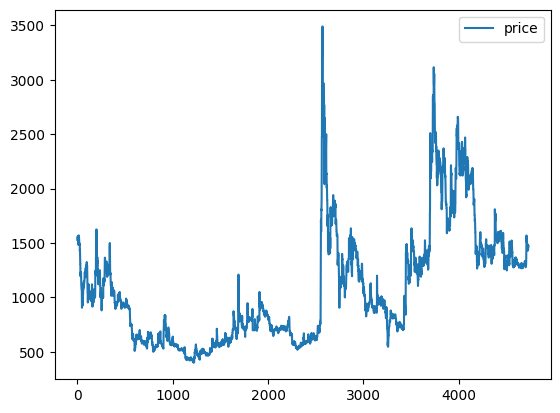

In [51]:
import matplotlib.pyplot as plt

pd.DataFrame(data).plot()

In [52]:
from statsmodels.tsa.stattools import adfuller
def adftest(data):
    #adf 검정!
    result = adfuller(data)

    print('정상성이 있는지 판단 : ')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return key
key = adftest(data)

정상성이 있는지 판단 : 
ADF Statistic: -2.792635
p-value: 0.059333
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [53]:
from statsmodels.tsa.arima.model import ARIMA #아리마 라이브러리

def ARIMA_model(data):
    #델타yt의 경우와 그냥 yt의 경우에 감마의 값에 따라 평균회귀 가능성이 어떻게 달라지는지 조심하세요
    model = ARIMA(data, order=(1, 0, 0))
    model_fit = model.fit()
    print(f'λ 값의 유도(델타yt가 아닌 그냥 yt임 주의!!) : { model_fit.params[1] }')
    half = -np.log(2)/(model_fit.params[1]-1)
    print(f'반감기 : {half}')

    display(model_fit.summary())
    return half
half=ARIMA_model(data)

λ 값의 유도(델타yt가 아닌 그냥 yt임 주의!!) : 0.9963690997817976
반감기 : 190.902293895342


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                 4731
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -24734.851
Date:                Tue, 02 Apr 2024   AIC                          49475.701
Time:                        11:14:46   BIC                          49495.087
Sample:                             0   HQIC                         49482.515
                               - 4731                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1077.7381    252.980      4.260      0.000     581.907    1573.569
ar.L1          0.9964      0.001   1122.785      0.000       0.995       0.998
sigma2      2033.7542      8.025    253.421      0.000    2018.025    2049.483
===================================================================================
Ljung-Box (L1) (Q):                   1.49   Jarque-Bera (JB):            690935.57
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               3.94   Skew:                             2.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        62.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
import numpy as np
from sklearn.linear_model import LinearRegression
data = data.to_numpy()

#허스트 지수 유도를 위한 RS 공식(변동성) 함수
def RS_func(data):
    L = np.log10(data[1:] / data[:-1])
    Z = np.mean(L)
    C = np.cumsum(L-Z)
    R = max(C) - min(C)
    S = np.std(L)

    if R == 0 or S == 0:
        return 0

    return R / S

#허스트 지수 검정 계산  <- basic exponent
def hurst_func(data):
    min_window = 10
    max_window = len(data) - 1
    by_factor = np.log10(2.0)
    window_sizes = list(map(lambda x: int(10 ** x),np.arange(np.log10(min_window), np.log10(max_window), by_factor)))
    window_sizes.append(len(data))

    RS = []
    for w in window_sizes:
        rs = []
        for start in range(0, len(data), w):
            if (start + w) > len(data):
                break
            res = RS_func(data[start:start + w].astype(np.float64))
            if res != 0:
                rs.append(res)
        RS.append(np.mean(rs))

    lm1 = LinearRegression().fit(np.log10(window_sizes).reshape(-1, 1),np.log10(RS).reshape(-1, 1))
    hurst_exp = lm1.coef_[0][0]
    return hurst_exp


hurst_func(data)




0.5158574290134457

In [60]:
# 백테스트를 위한 포지션 함수
def position(data,half):
    overall_mean = np.mean(data)
    overall_std = np.std(data)
    overall_mean, overall_std
    df = pd.DataFrame(data, columns=['price'])
    df['mean'] = overall_mean
    df['std'] = overall_std
    df['upper'] = overall_mean + 2*overall_std
    df['lower'] = overall_mean - 2*overall_std

    holding_period = half  # 가정한 보유 기간
    stop_loss_threshold = 0.2  # 손절 기준
    positions = []

    for i in range(1, len(df)):
        current_price = df.iloc[i]['price']
        previous_price = df.iloc[i-1]['price']
        upper_bound = df.iloc[i]['upper']
        lower_bound = df.iloc[i]['lower']

        if not positions or positions[-1]['exit_price'] is not None:
            if previous_price > upper_bound and current_price <= upper_bound:
                positions.append({'type': 'short', 'entry_price': current_price, 'entry_index': i, 'exit_price': None})
            elif previous_price < lower_bound and current_price >= lower_bound:
                positions.append({'type': 'long', 'entry_price': current_price,'entry_index': i,  'exit_price': None})

        if positions and positions[-1]['exit_price'] is None:
            position = positions[-1]
            elapsed_time = i - position['entry_index']
            loss = 0

            if position['type'] == 'long':
                loss = (current_price - position['entry_price']) / position['entry_price']
            else:
                loss = (position['entry_price'] - current_price) / position['entry_price']

            #손절,익절 공식 : 스탑로스컷 맞는지 확인 and 보유기간 넘는지 확인 and 평균 돌아왔는지
            if  elapsed_time > holding_period or (position['type'] == 'long' and current_price >= overall_mean) or (position['type'] == 'short' and current_price <= overall_mean):
                position['exit_price'] = current_price
                position['pnl'] = loss
                position['elapsed_day']= elapsed_time

    positions_summary = [{'type': p['type'], 'entry_price': p['entry_price'], 'exit_price': p['exit_price'], 'pnl': p['pnl'],'entry_day':p['entry_index'],'elapsed_day':p['elapsed_day']} for p in positions if p['exit_price'] is not None]
    return positions_summary


In [61]:
positions = position(data,half)
positions[:]

[{'type': 'short',
  'entry_price': 2040.0,
  'exit_price': 905.0,
  'pnl': 0.5563725490196079,
  'entry_day': 2591,
  'elapsed_day': 157},
 {'type': 'short',
  'entry_price': 2110.0,
  'exit_price': 1680.0,
  'pnl': 0.2037914691943128,
  'entry_day': 3704,
  'elapsed_day': 191},
 {'type': 'short',
  'entry_price': 2125.0,
  'exit_price': 2120.0,
  'pnl': 0.002352941176470588,
  'entry_day': 3921,
  'elapsed_day': 191},
 {'type': 'short',
  'entry_price': 2120.0,
  'exit_price': 1401.0,
  'pnl': 0.3391509433962264,
  'entry_day': 4138,
  'elapsed_day': 191}]

In [62]:
import matplotlib.pyplot as plt
# 포지션 가지구 백테스트
def backtest(positions):
    initial_capital = 1000000

    capital = initial_capital
    capital_history = [capital]

    for position in positions:
        if position['exit_price']:
            pnl = position['pnl']
            profit = capital * pnl
            capital += profit
            capital_history.append(capital)
    time_stamps = [i for i, _ in enumerate(capital_history)]

    # 그래프 초기화 및 그리기
    plt.figure(figsize=(14, 7))
    plt.plot(time_stamps, capital_history, label='Capital Over Time', color='blue', marker='o')

    plt.title('Portfolio Value Over Time')
    plt.xlabel('days')
    plt.ylabel('Portfolio Value')
    plt.legend()

    plt.show()

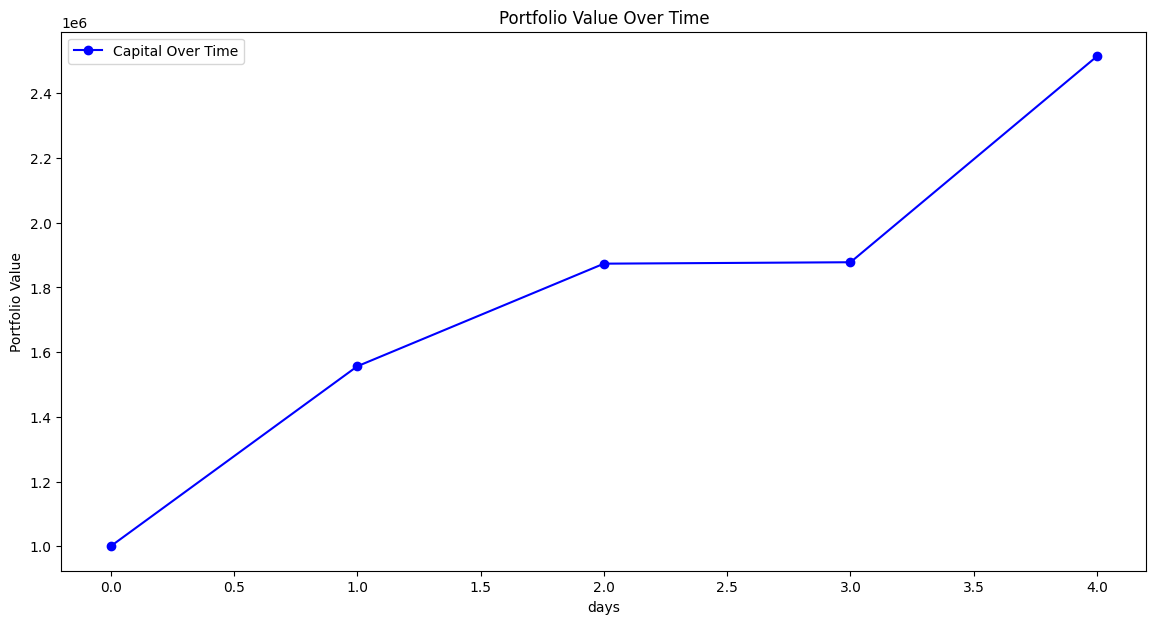

In [63]:
backtest(positions)

[{'type': 'short',
  'entry_price': 2040.0,
  'exit_price': 905.0,
  'pnl': 0.5563725490196079,
  'entry_day': 2591,
  'elapsed_day': 157},
 {'type': 'short',
  'entry_price': 2110.0,
  'exit_price': 1680.0,
  'pnl': 0.2037914691943128,
  'entry_day': 3704,
  'elapsed_day': 191},
 {'type': 'short',
  'entry_price': 2125.0,
  'exit_price': 2120.0,
  'pnl': 0.002352941176470588,
  'entry_day': 3921,
  'elapsed_day': 191},
 {'type': 'short',
  'entry_price': 2120.0,
  'exit_price': 1401.0,
  'pnl': 0.3391509433962264,
  'entry_day': 4138,
  'elapsed_day': 191}]

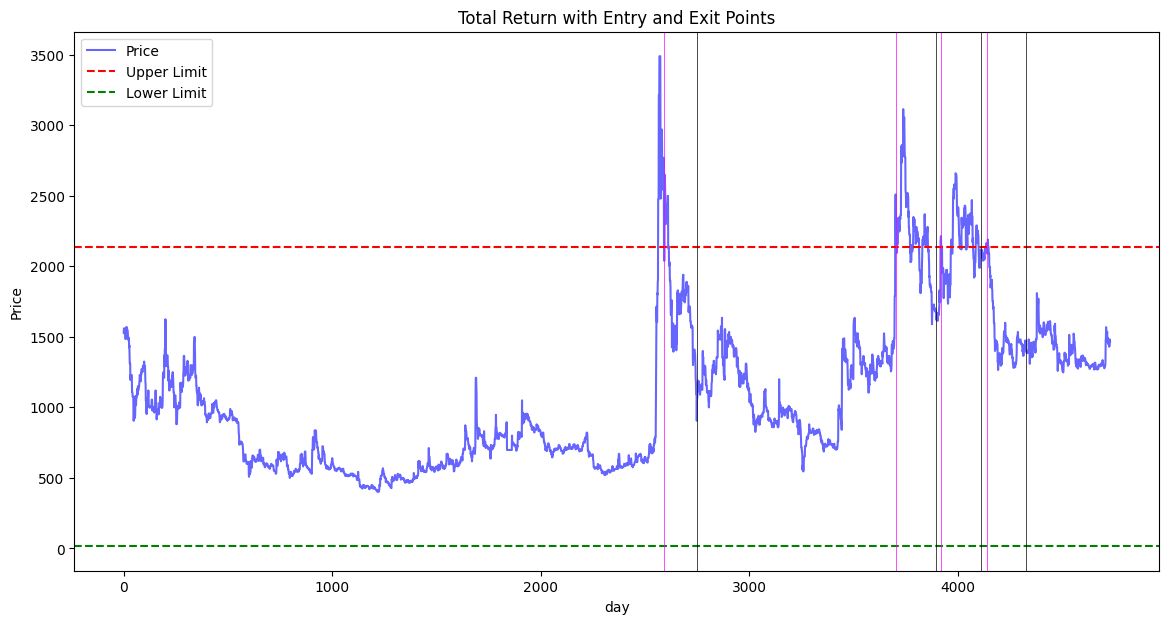

In [64]:
#포지션 진입 시점과 종료 시점 그래프
def when(data):
    overall_mean = np.mean(data)
    overall_std = np.std(data)
    overall_mean, overall_std
    df = pd.DataFrame(data, columns=['price'])
    df['mean'] = overall_mean
    df['std'] = overall_std
    df['upper'] = overall_mean + 2*overall_std
    df['lower'] = overall_mean - 2*overall_std

    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['price'], label='Price', color='blue', alpha=0.6)
    plt.axhline(y=overall_mean + 2*overall_std, color='red', linestyle='--', label='Upper Limit')
    plt.axhline(y=overall_mean - 2*overall_std, color='green', linestyle='--', label='Lower Limit')
    display(positions)

    for position in positions:
        entry_index = position['entry_day']
        if position['exit_price']:
            exit_index = position['entry_day'] + position['elapsed_day']
            if position['type'] == 'long':
                plt.axvline(x=entry_index, color='gold', linestyle='-', linewidth=0.5)
                plt.axvline(x=exit_index, color='black', linestyle='-', linewidth=0.5)
            else:
                plt.axvline(x=entry_index, color='magenta', linestyle='-', linewidth=0.5)
                plt.axvline(x=exit_index, color='black', linestyle='-', linewidth=0.5)

    plt.legend()
    plt.title('Total Return with Entry and Exit Points')
    plt.xlabel('day')
    plt.ylabel('Price')
    plt.show()

when(data)